## Sample size calculations for various approaches
Calculating the sample sizes for various approaches to answering the following questions
1. For evals where a code review or testing reveals a problem, how many transcripts must be evaluated to determine whether a benchmark has at least one violation demonstrated (Section 1)?
2. What percentage of transcripts demonstrate this violation? (Section 2)
3. For transcripts which demonstrate violations (as determined by gold standard human graders), how often is this violation detected by automated transcript analysis via scanners? (Section 3)
    - **This notebook** does this analysis, finding the n needed to achieve different levels of precision under different assumptions.


## 3. Estimating the confidence interval on a Se calculation given a sample size

If we have a set of labeled true positives, we'd like to know things like
1. what is the CI on the point sensitivity measured on this dataset
2. what is the one sided lowerbound (i.e., what kind of guarantees about how good this test is)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [ ]:
# Computing confidence interval for a known dataset (e.g., already have the labeled data)

#These are computing the clopper-pearson confidence intervals
# If I wanted alternatives I could do a wilson score or bayesian credible interval

#x here is the number of identified positives (TP), n is to total number of positives in the dataset (so n-x false negatives)
def cp_two_sided(x, n, alpha=0.05):
    lower = 0.0 if x == 0 else beta.ppf(alpha/2, x, n - x + 1)
    upper = 1.0 if x == n else beta.ppf(1 - alpha/2, x + 1, n - x)
    return lower, upper

def cp_lower_one_sided(x, n, alpha=0.05):
    # 1-alpha lower confidence bound
    return 0.0 if x == 0 else beta.ppf(alpha, x, n - x + 1)

# example:
# x = 180; n = 200
print(cp_two_sided(180, 200))
print(cp_lower_one_sided(180, 200))


(np.float64(0.8497872121322442), np.float64(0.937840633745934))
0.8580107484090549


So this gives us a pretty straightforward way to calculate the halfwidth assuming different numbers for n and seitivity (here n is the number of positives, not the number of samples)

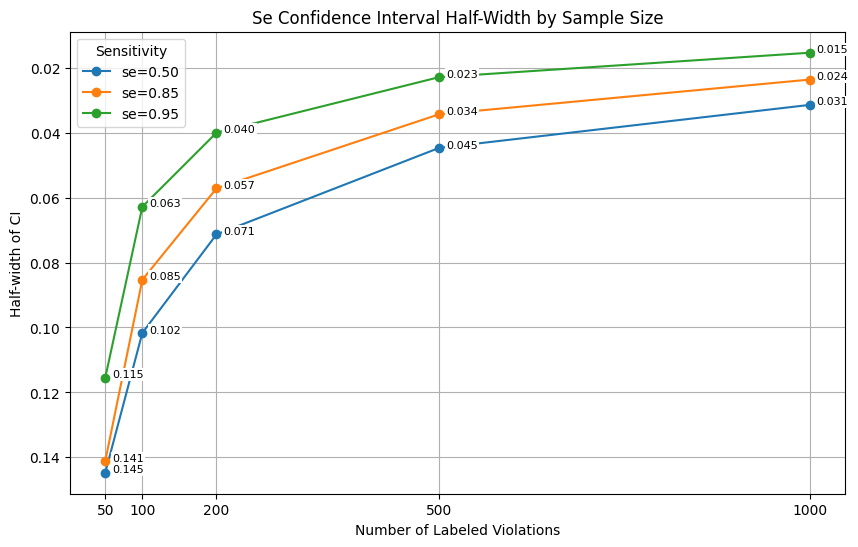

In [ ]:

# Define ranges
#sensitivities = np.arange(0.70, 1.0, 0.05)  # e.g., 0.70, 0.75, ..., 0.95
ses = [0.5, 0.85, 0.95]
n_values = [50, 100, 200, 500, 1000]

# Build dataframe
rows = []
for se in ses:
    for n in n_values:
        x = int(n * se)
        lower, upper = cp_two_sided(x, n)
        half_width = se - lower
        rows.append({
            'sensitivity': se,
            'n': n,
            'x': x,
            'lower': lower,
            'upper': upper,
            'half_width': half_width
        })

df = pd.DataFrame(rows)
df

fig, ax = plt.subplots(figsize=(10, 6))

for se in df['sensitivity'].unique():
    subset = df[df['sensitivity'] == se]
    ax.plot(subset['n'], subset['half_width'], marker='o', label=f'se={se:.2f}')
        # Add labels at points
    for _, row in subset.iterrows():
        ax.annotate(f'{row["half_width"]:.3f}', 
                    (row['n'], row['half_width']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax.set_xlabel('Number of Labeled Violations')
ax.set_ylabel('Half-width of CI')
ax.set_title('Se Confidence Interval Half-Width by Sample Size')
ax.legend(title='Sensitivity')
ax.grid(True)
ax.set_xticks(n_values)

#ax.set_xscale('log')
ax.invert_yaxis()
plt.show()


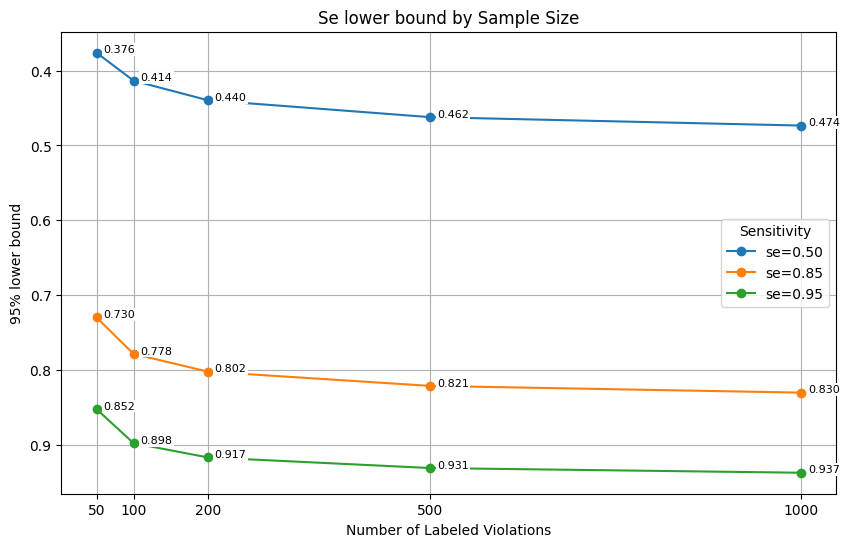

In [24]:


# Define ranges
#sensitivities = np.arange(0.70, 1.0, 0.05)  # e.g., 0.70, 0.75, ..., 0.95
ses = [0.5, 0.85, 0.95]
n_values = [50, 100, 200, 500, 1000]

# Build dataframe
rows = []
for se in ses:
    for n in n_values:
        x = int(n * se)
        lower_bound = cp_lower_one_sided(x, n)
        rows.append({
            'sensitivity': se,
            'n': n,
            'x': x,
            'lower_bound': lower_bound
        })

df = pd.DataFrame(rows)
df

fig, ax = plt.subplots(figsize=(10, 6))

for se in df['sensitivity'].unique():
    subset = df[df['sensitivity'] == se]
    ax.plot(subset['n'], subset['lower_bound'], marker='o', label=f'se={se:.2f}')
        # Add labels at points
    for _, row in subset.iterrows():
        ax.annotate(f'{row["lower_bound"]:.3f}', 
                    (row['n'], row['lower_bound']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax.set_xlabel('Number of Labeled Violations')
ax.set_ylabel(f'95% lower bound')
ax.set_title('Se lower bound by Sample Size')
ax.legend(title='Sensitivity')
ax.grid(True)
ax.set_xticks(n_values)

#ax.set_xscale('log')
ax.invert_yaxis()
plt.show()



## 2. More efficient labeling approach
Now we get into the hard thing, which is what if we don't want to do random sampling for finding our n_+ because the prevalence might be very low and we don't want to run 1000 samples?

The way to do this is to run the scanner first on the entire dataset, and use that to build an "enriched" dataset. This might make the most sense for a validation set rather than for the test set.

Here are the steps.
1. Run the scanner on entire sample (say sample is 1000 for simplicity)
2. Identify n_p+ putative positives from the scanner (say this is 100)
3. Validate the positives, this gives TP for the Se equation
4. Take a random sample from the remaining putative negatives (say 100)
5. Grade that sample to identify false negatives. This gives you an estimate of the number of FN/100, which you will be reweighting (in this case * 900/100) (IPW)
6. Take the 95% CI on that estimate, and use it to calculate the 95% estimate of Se by plugging in the bounds for FN

In [69]:


# I want to run this as a simulation: sample 1000 times with p=FN_rate and p = TP_rate to get confidence intervals
# Simulate 1000 samples
# n_simulations = 1000

# FN_samples = np.random.binomial(n=n_g, p=FN_rate, size=n_simulations)
# TP_samples = np.random.binomial(n=n_g, p=TP_rate, size=n_simulations)

# # 95% interval for FN - bootstrapped
# FN_lower = np.percentile(FN_samples, 2.5) * (N-TP)/n_g
# FN_upper = np.percentile(FN_samples, 97.5) * (N-TP)/n_g

# print(f"FN 2.5%: {FN_lower}, FN 97.5%: {FN_upper}")

# Se_lower = TP/(FN_lower + TP)
# Se_upper = TP/(FN_upper + TP)
# print(f"SE 2.5%: {Se_lower}, Se 97.5%: {Se_upper}")

# doing the same with exact

import scipy.stats as st
# I want to run some estimates at doing this. This is like an inverted form of the analysis I did in part 2.
# given x positives in a binary sample of n, get 95% CI on the true positive rate p
# compute confidence bounds on Se as TP /(TP +- CI bounds)

N = 1000 #total number of transcripts
n_g = 100 #sample of negatives we are willing to grade
FN_rate = 0.00 #assume 3% false negative rate
TP_rate = 0.15 #true positive rate.

TP = N*TP_rate #count of true positives

x= round(n_g * FN_rate) #here with a certain number of observations based on FN rate
alpha = 0.05

# Clopper–Pearson (exact)
lower_cp = st.beta.ppf(alpha/2, x, n_g-x+1)
upper_cp = st.beta.ppf(1-alpha/2, x+1, n_g-x)
#print(lower_cp, upper_cp) # these are the probabilities. To convert them to counts we need to multiply them and round
lower_cp_n = lower_cp * (N-TP)
mid_cp = x * (N-TP)/n_g
upper_cp_n = upper_cp * (N-TP)
#print(lower_cp_n, upper_cp_n) 

Se_lower = TP/(lower_cp_n + TP)
Se_mid = TP/(mid_cp+TP)
Se_upper = TP/(upper_cp_n + TP)
print(f"SE 2.5%: {Se_lower}, mid: {Se_mid}, Se 97.5%: {Se_upper}")


# x = 5 #here with a certain number of observations
# alpha = 0.05

# Clopper–Pearson (exact)
# lower_cp = st.beta.ppf(alpha/2, x, n_g-x+1)
# upper_cp = st.beta.ppf(1-alpha/2, x+1, n_g-x)
# #print(lower_cp, upper_cp) # these are the probabilities. To convert them to counts we need to multiply them and round
# lower_cp_n = lower_cp * (N-TP)
# mid_cp = x * (N-TP)/n_g
# upper_cp_n = upper_cp * (N-TP)
# #print(lower_cp_n, upper_cp_n) 

# Se_lower = TP/(lower_cp_n + TP)
# Se_mid = TP/(mid_cp+TP)
# Se_upper = TP/(upper_cp_n + TP)
# print(f"SE 2.5%: {Se_lower}, mid: {Se_mid}, Se 97.5%: {Se_upper}")

SE 2.5%: nan, mid: 1.0, Se 97.5%: 0.8297185779269516
